ERREUR: Fichier 'data/EURUSD_H1.csv' non trouvé. Utilisation d'un jeu de données de démo.
Lignes supprimées par dropna: 13 (lookback feature / lookahead target)
Matrice de corrélation :
          RSI_14    target
RSI_14  1.000000  0.010953
target  0.010953  1.000000


/var/folders/rm/31t8h7qd3q9f6g5qw1z5dc800000gn/T/ipykernel_66460/2378765025.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2023-01-01", periods=1000, freq='H')


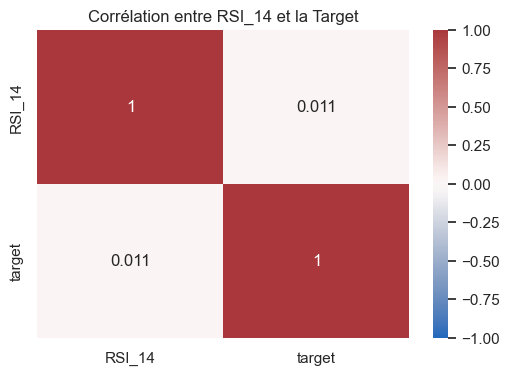

/var/folders/rm/31t8h7qd3q9f6g5qw1z5dc800000gn/T/ipykernel_66460/2378765025.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y=FEATURE_NAME, data=df_analysis, palette='vlag')


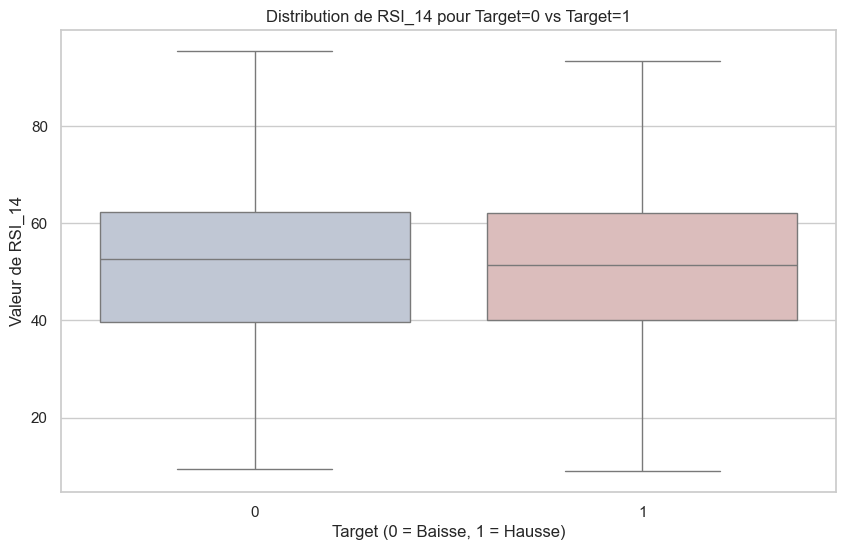

Taux de succès (moyenne de Target) par quantile :
feature_quantile
0    0.464646
1    0.517766
2    0.507614
3    0.507614
4    0.464646
Name: target, dtype: float64


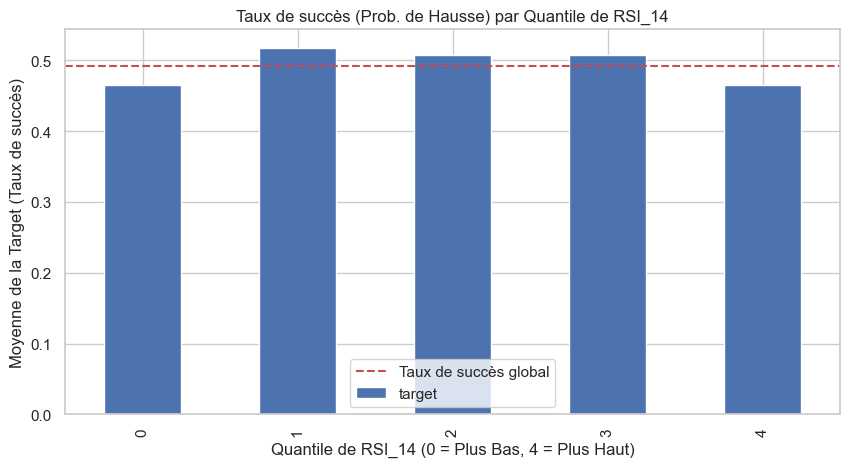

Taille Train: 690 | Taille Test: 297

--- ÉVALUATION SUR LE SET DE TEST ---
Précision (Accuracy) du modèle: 0.4916
Précision de base (Benchmark):   0.5051

>> VERDICT: Le modèle NE BAT PAS le benchmark. La feature semble peu ou pas explicative.

--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       0.50      0.81      0.62       150
           1       0.46      0.17      0.25       147

    accuracy                           0.49       297
   macro avg       0.48      0.49      0.43       297
weighted avg       0.48      0.49      0.43       297


--- Matrice de Confusion ---


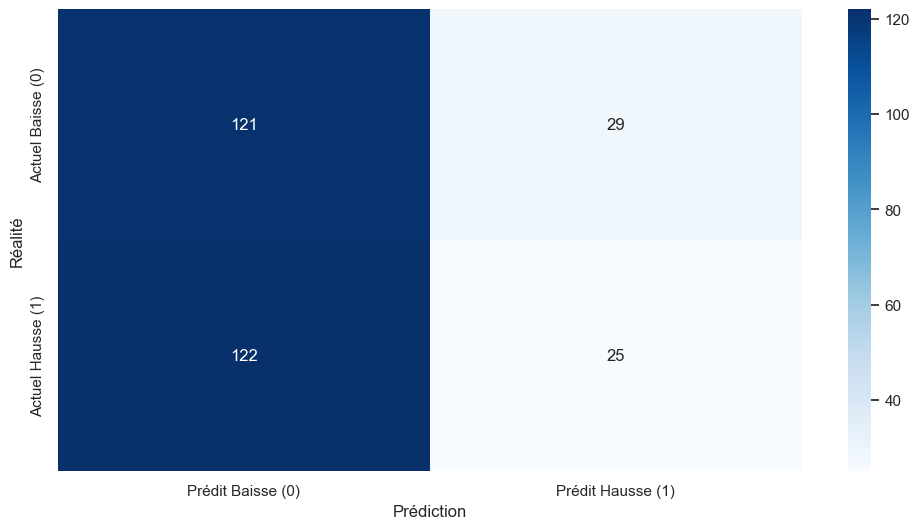

In [ ]:
#
# Jupyter Notebook (.ipynb) Template
#
# OBJECTIF: Template robuste pour tester l'explicativité d'une feature (Forex).
#

# %% [markdown]
# ## 1. Importations

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuration de l'affichage
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %% [markdown]
# ## 2. Configuration

# %%
# TODO: Spécifier le chemin vers les données
# Doit contenir au minimum: 'timestamp', 'open', 'high', 'low', 'Close'
FILE_PATH = "data/EURUSD_H1.csv"

# TODO: Définir l'horizon de prédiction (en nombre de périodes)
TARGET_SHIFT_PERIODS = 1

# Variable globale pour le nom de la feature
FEATURE_NAME = ""

# %% [markdown]
# ## 3. Chargement des Données

# %%
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"ERREUR: Fichier '{FILE_PATH}' non trouvé. Utilisation d'un jeu de données de démo.")
    dates = pd.date_range(start="2023-01-01", periods=1000, freq='H')
    price = 1.10 + np.cumsum(np.random.randn(1000) * 0.001)
    df = pd.DataFrame({
        'timestamp': dates,
        'open': price - 0.0005, 'high': price + 0.0005,
        'low': price - 0.0005, 'Close': price,
        'volume': np.random.randint(100, 1000, size=1000)
    })

# Conversion du timestamp en index Datetime
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')


# %% [markdown]
# ## 4. Calcul de la Feature (PARTIE À MODIFIER)
#
# > **Instruction :** Remplacez le contenu de la fonction `calculer_ma_feature` par votre propre logique.
# > La fonction doit retourner (pandas.Series, str).

# %%
def calculer_ma_feature(data):
    """
    Calcule la feature à tester.
    PREND: un DataFrame pandas (data) avec les colonnes OHLC.
    RETOURNE: (pandas.Series, str) -> (série de la feature, nom de la feature)
    """
    
    # --- DÉBUT DE LA ZONE MODIFIABLE ---
    
    # EXEMPLE: Un simple RSI (Relative Strength Index)
    period = 14
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    perte = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / perte
    rsi = 100 - (100 / (1 + rs))
    
    # Assignation des valeurs de retour
    feature_series = rsi
    feature_name = "RSI_14"

    # --- FIN DE LA ZONE MODIFIABLE ---
    
    if not isinstance(feature_series, pd.Series):
        raise TypeError("La feature doit être une pandas.Series.")
        
    return feature_series.rename(feature_name), feature_name

# --- Exécution du calcul de la feature ---
df_feature, FEATURE_NAME = calculer_ma_feature(df)
df[FEATURE_NAME] = df_feature


# %% [markdown]
# ## 5. Définition de la Cible (Target)
#
# Définition de la variable binaire à prédire.
# * **Target = 1** si `Close` futur > `Close` actuel (Hausse)
# * **Target = 0** si `Close` futur <= `Close` actuel (Baisse ou Stagnation)

# %%
df['future_Close'] = df['Close'].shift(-TARGET_SHIFT_PERIODS)
df['target'] = (df['future_Close'] > df['Close']).astype(int)


# %% [markdown]
# ## 6. Préparation des Données (Alignement & Nettoyage)
#
# Alignement temporel de la feature (T) et de la target (T+N) et suppression des NaN induits.

# %%
df_analysis = df[[FEATURE_NAME, 'target']].copy()

initial_rows = len(df_analysis)
df_analysis = df_analysis.dropna()
final_rows = len(df_analysis)

print(f"Lignes supprimées par dropna: {initial_rows - final_rows} (lookback feature / lookahead target)")

# %% [markdown]
# ## 7. Analyse Exploratoire (EDA)

# %% [markdown]
# ### 7.1. Corrélation

# %%
correlation = df_analysis.corr()
print("Matrice de corrélation :")
print(correlation)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title(f"Corrélation entre {FEATURE_NAME} et la Target")
plt.show()

# %% [markdown]
# ### 7.2. Distribution de la Feature vs Target

# %%
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=FEATURE_NAME, data=df_analysis, palette='vlag')
plt.title(f"Distribution de {FEATURE_NAME} pour Target=0 vs Target=1")
plt.xlabel("Target (0 = Baisse, 1 = Hausse)")
plt.ylabel(f"Valeur de {FEATURE_NAME}")
plt.show()

# %% [markdown]
# ### 7.3. Analyse par Quantiles

# %%
try:
    # Création de 5 "bacs" (quantiles) pour la feature
    df_analysis['feature_quantile'] = pd.qcut(df_analysis[FEATURE_NAME], 5, labels=False, duplicates='drop')
    
    # Calcul de la moyenne de la target pour chaque quantile
    quantile_analysis = df_analysis.groupby('feature_quantile')['target'].mean()

    print("Taux de succès (moyenne de Target) par quantile :")
    print(quantile_analysis)

    # Visualisation
    quantile_analysis.plot(kind='bar', figsize=(10, 5))
    plt.title(f"Taux de succès (Prob. de Hausse) par Quantile de {FEATURE_NAME}")
    plt.ylabel("Moyenne de la Target (Taux de succès)")
    plt.xlabel(f"Quantile de {FEATURE_NAME} (0 = Plus Bas, 4 = Plus Haut)")
    plt.axhline(df_analysis['target'].mean(), color='r', linestyle='--', label='Taux de succès global')
    plt.legend()
    plt.show()

except ValueError as e:
    print(f"AVERTISSEMENT (Quantiles): {e}. (Arrive si la feature a trop peu de valeurs uniques.)")


# %% [markdown]
# ## 8. Modélisation (Test de Prédictivité)
#
# Entraînement d'un modèle simple (Régression Logistique) pour quantifier le pouvoir prédictif.

# %%
X = df_analysis[[FEATURE_NAME]]
y = df_analysis['target']

if len(X) < 50:
    print("ERREUR: Pas assez de données pour la modélisation (après nettoyage).")
else:
    # Séparation Train/Test (SANS MÉLANGE pour respecter la chronologie)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    print(f"Taille Train: {len(X_train)} | Taille Test: {len(X_test)}")

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entraînement
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # Évaluation
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Benchmark = Prédire la classe majoritaire
    benchmark_accuracy = y_test.value_counts(normalize=True).max()

    print("\n--- ÉVALUATION SUR LE SET DE TEST ---")
    print(f"Précision (Accuracy) du modèle: {accuracy:.4f}")
    print(f"Précision de base (Benchmark):   {benchmark_accuracy:.4f}")

    if accuracy > benchmark_accuracy:
        print("\n>> VERDICT: Le modèle bat le benchmark. La feature semble avoir un pouvoir prédictif.")
    else:
        print("\n>> VERDICT: Le modèle NE BAT PAS le benchmark. La feature semble peu ou pas explicative.")

    # Rapport de classification
    print("\n--- Rapport de Classification ---")
    print(classification_report(y_test, y_pred))

    # Matrice de Confusion
    print("\n--- Matrice de Confusion ---")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Prédit Baisse (0)', 'Prédit Hausse (1)'],
                yticklabels=['Actuel Baisse (0)', 'Actuel Hausse (1)'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.show()


# %% [markdown]
# ## 9. Conclusion
#
# **Analyse par Quantiles :**
# * [La relation était-elle monotone ? (ex: le quantile 4 avait-il le taux de succès le plus élevé et le 0 le plus bas ?)]
#
# **Performance du Modèle :**
# * [Le modèle a-t-il battu le benchmark (précision de base) ? Si oui, de combien ?]
#
# **Verdict Final :**
# > [Rédigez votre conclusion ici. La feature `NOM_DE_VOTRE_FEATURE` semble-t-elle explicative ?]
#

# %%